## ResNet
In theory a sufficiently deep neural network can learn any arbitrarily complex function, but in practice training a very deep NN is very hard because of the problem of vanishing gradients. **ResNets** solve this problem by introducing a **Skip connection** which makes it easy to learn the identity function. **ResNet** architecture has been very succesful in helping to train very deep Neural Networks. In this notebook we will build a **ResNet** model from scratch in TensorFlow. Original idea of ResNet was from He K. et. al. in the below publication.

https://arxiv.org/abs/1512.03385

In [1]:
#Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#import Keras
from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Add
from keras.models import Model

from keras.initializers import glorot_uniform

In [2]:
#Lets make an identity block of ResNet 
#For this block we assume that the dimenstions of a[l] and a[l+2] are the same
def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)  
    return X

In [3]:
#When the dimensions of a[l] and a[l+2] are not the same a convolution block is added on the shortcut path to make them same
def convolutional_block(X, f, filters, stage, block, s = 2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
  
    X_shortcut = X

    X = Conv2D(F1, kernel_size=(1, 1), strides = (s,s), padding='valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(F2, kernel_size=(f, f), strides = (1,1), padding='same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(F3, kernel_size=(1, 1), strides = (1,1), padding='valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    X_shortcut = Conv2D(F3, kernel_size=(1, 1), strides = (s,s), padding='valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [4]:
#Let join these together and make ResNet50 model
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
   
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D((2,2))(X)
    
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)

    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [5]:
model = ResNet50(input_shape = (180, 180, 3), classes = 5)

In [6]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 186, 186, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 90, 90, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 90, 90, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [7]:
#Load the flowers dataset 
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [8]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 1s 0us/step


In [9]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


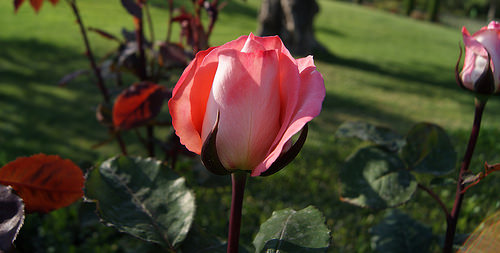

In [10]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

In [11]:
batch_size = 32
img_height = 180
img_width = 180

In [12]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [13]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [14]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


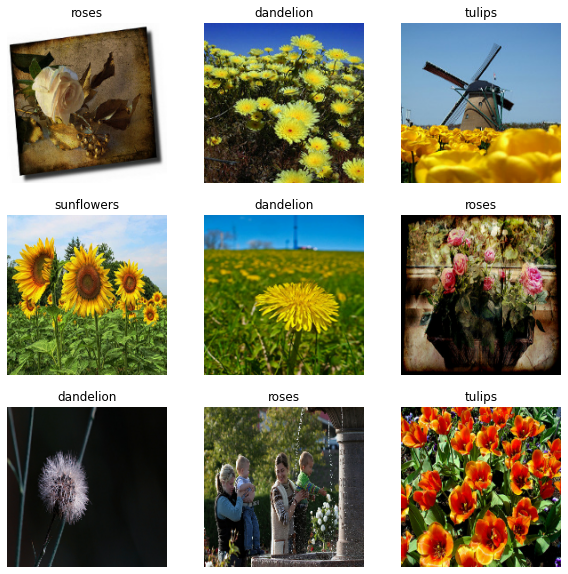

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [17]:
#Normalize the datasets
from tensorflow.keras import layers
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

train_norm_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(train_norm_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

val_norm_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

0.0 0.96902645


In [18]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
r = model.fit(
  train_norm_ds,
  validation_data=val_norm_ds,
  epochs=25
)

Epoch 1/25
92/92 [==============================] - 29s 315ms/step - loss: 5.1931 - accuracy: 0.2926 - val_loss: 62.7748 - val_accuracy: 0.1785
Epoch 2/25
92/92 [==============================] - 27s 298ms/step - loss: 2.3169 - accuracy: 0.4339 - val_loss: 1.7338 - val_accuracy: 0.2766
Epoch 3/25
92/92 [==============================] - 28s 301ms/step - loss: 1.7387 - accuracy: 0.5072 - val_loss: 3.6340 - val_accuracy: 0.3896
Epoch 4/25
92/92 [==============================] - 28s 303ms/step - loss: 1.6479 - accuracy: 0.5528 - val_loss: 1.9346 - val_accuracy: 0.3569
Epoch 5/25
92/92 [==============================] - 28s 305ms/step - loss: 1.6920 - accuracy: 0.5797 - val_loss: 1.4201 - val_accuracy: 0.5599
Epoch 6/25
92/92 [==============================] - 28s 306ms/step - loss: 1.3835 - accuracy: 0.5831 - val_loss: 1.9201 - val_accuracy: 0.6308
Epoch 7/25
92/92 [==============================] - 28s 308ms/step - loss: 1.2558 - accuracy: 0.5892 - val_loss: 1.8471 - val_accuracy: 0.604

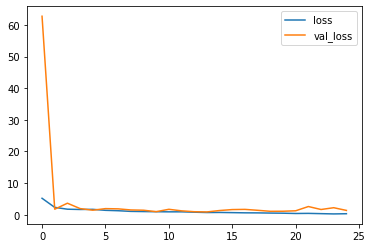

In [20]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

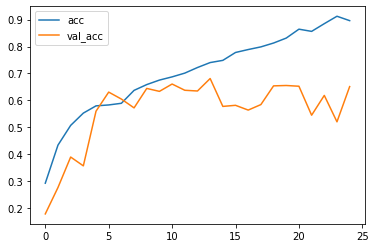

In [21]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

Model seems to be overfitting after Epoch 5. Maybe adding some Dropout layers would improve the model performance. Given GPU constraints we will leave it here.